# Wasserstein Pareto Frontier Experiment on COMPAS Data Set

## Import Data
The experiment used the COMPAS data set as in "Optimized Pre-Processing for Discrimination Prevention" by Calmon and etc. for comparison purpose: https://github.com/fair-preprocessing/nips2017/tree/master/compas/experiment_data2

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, auc, classification_report, roc_curve
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from scipy.linalg import sqrtm
from matplotlib import gridspec
from matplotlib.patches import Rectangle

# import data
path =r'/Users/shizhouxu/Documents/LIBRARY/Python/Fair_L2_Supervised_Learning/experiment_data_compass/' # use your path
train_0 = pd.read_csv(path + "train_0.csv",index_col=None, header=0, usecols=range(1,6))
train_1 = pd.read_csv(path + "train_1.csv",index_col=None, header=0, usecols=range(1,6))
train_2 = pd.read_csv(path + "train_2.csv",index_col=None, header=0, usecols=range(1,6))
train_3 = pd.read_csv(path + "train_3.csv",index_col=None, header=0, usecols=range(1,6))
train_4 = pd.read_csv(path + "train_4.csv",index_col=None, header=0, usecols=range(1,6))
test_0 = pd.read_csv(path + "test_0.csv",index_col=None, header=0, usecols=range(1,6))
test_1 = pd.read_csv(path + "test_1.csv",index_col=None, header=0, usecols=range(1,6))
test_2 = pd.read_csv(path + "test_2.csv",index_col=None, header=0, usecols=range(1,6))
test_3 = pd.read_csv(path + "test_3.csv",index_col=None, header=0, usecols=range(1,6))
test_4 = pd.read_csv(path + "test_4.csv",index_col=None, header=0, usecols=range(1,6))
train_new_0 = pd.read_csv(path + "train_new_0.csv",index_col=None, header=0, usecols=range(1,6))
train_new_1 = pd.read_csv(path + "train_new_1.csv",index_col=None, header=0, usecols=range(1,6))
train_new_2 = pd.read_csv(path + "train_new_2.csv",index_col=None, header=0, usecols=range(1,6))
train_new_3 = pd.read_csv(path + "train_new_3.csv",index_col=None, header=0, usecols=range(1,6))
train_new_4 = pd.read_csv(path + "train_new_4.csv",index_col=None, header=0, usecols=range(1,6))
test_new_0 = pd.read_csv(path + "test_new_0.csv",index_col=None, header=0, usecols=range(1,6))
test_new_1 = pd.read_csv(path + "test_new_1.csv",index_col=None, header=0, usecols=range(1,6))
test_new_2 = pd.read_csv(path + "test_new_2.csv",index_col=None, header=0, usecols=range(1,6))
test_new_3 = pd.read_csv(path + "test_new_3.csv",index_col=None, header=0, usecols=range(1,6))
test_new_4 = pd.read_csv(path + "test_new_4.csv",index_col=None, header=0, usecols=range(1,6))

# all available data variables: features = ['race','age_cat','c_charge_degree','priors_count','is_recid']
features = ['race','age_cat','c_charge_degree','priors_count','is_recid']
# sensitive variable: Z_features = ['race']
Z_features = ['race']
# dependnet variable: Y_features = ['is_recid']
Y_features = ['is_recid']
# independnet variable: X_features = ['age_cat', 'c_charge_degree','priors_count']
X_features = ['age_cat', 'c_charge_degree','priors_count']

# combine the data by train/test category
TrainList=[train_0,train_1,train_2,train_3,train_4]
TestList=[test_0,test_1,test_2,test_3,test_4]
TrainNewList=[train_new_0,train_new_1,train_new_2,train_new_3,train_new_4]
TestNewList=[test_new_0,test_new_1,test_new_2,test_new_3,test_new_4]

# data set combined: df
ord_enc = OrdinalEncoder()
df = pd.concat([train_0,train_1,train_2,train_3,train_4,test_0,test_1,test_2,test_3,test_4])
# data set further excluding the sensitive variable: df_delete
df_delete = df.drop('race',axis = 1)
# sensitive variable Z: gender
race = df['race']

## Compute the Wasserstein Pseudo-barycenter for X

In [2]:
# independent variable: X
X = np.delete(np.array(pd.get_dummies(df[X_features])),[4],axis = 1)
# dependent variable: Y
Y = np.array(pd.get_dummies(df[Y_features]))

# mean of X and Y: X_mean, Y_mean
X_mean = np.mean(X,axis = 0)
Y_mean = np.mean(Y)

# covariance (matrix) of X and Y: X_cov, Y_cov
X_cov = np.cov(X.T)
Y_cov = np.cov(Y.T)

# marginal (conditional) dependent variables: X_male, Y_male
X_A = X[race == 'African-American',:]
Y_A = Y[race == 'African-American']
X_C = X[race == 'Caucasian',:]
Y_C = Y[race == 'Caucasian']

# marginal mean: X_(fe)male_mean, Y_(fe)male_mean
X_A_mean = np.average(X_A, axis = 0)
Y_A_mean = np.average(Y_A)
X_C_mean = np.average(X_C, axis = 0)
Y_C_mean = np.average(Y_C)

# marginal covariance: X_(fe)male_cov, Y_(fe)male_cov, 
X_A_cov = np.cov(X_A.T)
Y_A_cov = np.cov(Y_A.T)
X_C_cov = np.cov(X_C.T)
Y_C_cov = np.cov(Y_C.T)

# cross-covariance (matrix) between Y and X: yX_(fe)male_cov
yX_A_cov = np.cov(Y_A.T, X_A.T)[range(len(Y[0,:]),len(Y[0,:]) + len(X[0,:])),0]
yX_C_cov = np.cov(Y_C.T, X_C.T)[range(len(Y[0,:]),len(Y[0,:]) + len(X[0,:])),0]

# algorithm 1, step 1: iterative process to the independent barycenter covariance matrix with stop cirterion error equals 0.00000001
sample_size = len(X[:,0])
X_bar = np.random.rand(len(X[0,:]),len(X[0,:])) # random initialization for the covariance
eps = 10 # initialization for the stop variable

while eps > 0.00000001:
    X_new = ((len(X_A[:,0])/sample_size) * sqrtm(sqrtm(X_bar)@X_A_cov@sqrtm(X_bar))) + ((len(X_C[:,0])/sample_size) * sqrtm(sqrtm(X_bar)@X_C_cov@sqrtm(X_bar)))
    eps = np.linalg.norm(X_bar - X_new)
    X_bar = X_new
    
# algorithm 1, step 2: the corresponding Brenier's map for marginals of X: T_X_(fe)male
T_X_A = np.linalg.inv(sqrtm(X_A_cov)) @ sqrtm( sqrtm(X_A_cov) @ X_bar @ sqrtm(X_A_cov) ) @ np.linalg.inv(sqrtm(X_A_cov))
T_X_C = np.linalg.inv(sqrtm(X_C_cov)) @ sqrtm( sqrtm(X_C_cov) @ X_bar @ sqrtm(X_C_cov) ) @ np.linalg.inv(sqrtm(X_C_cov))

# wasserstein pseudo-barycenter for X separated in train/test categories: X_TrainFairList, X_TestFairList
X_TrainFairList = []
X_TestFairList = []

for i in range(0,len(TrainList)):
    train = np.delete(np.array(pd.get_dummies(TrainList[i][X_features])),[4],axis = 1)
    test = np.delete(np.array(pd.get_dummies(TestList[i][X_features])),[4],axis = 1)
    gender_train_i = np.array(TrainList[i][Z_features]).T[0,:]
    gender_test_i = np.array(TestList[i][Z_features]).T[0,:]
    train_new = np.random.rand(train.shape[0],train.shape[1])
    test_new = np.random.rand(test.shape[0],test.shape[1])
    train_new[gender_train_i == 'African-American',:] = (train[gender_train_i == 'African-American',:] - X_A_mean) @ T_X_A.T + X_mean
    train_new[gender_train_i == 'Caucasian',:] = (train[gender_train_i == 'Caucasian',:] - X_C_mean) @ T_X_C.T + X_mean
    test_new[gender_test_i == 'African-American',:] = (test[gender_test_i == 'African-American',:] - X_A_mean) @ T_X_A.T + X_mean
    test_new[gender_test_i == 'Caucasian',:] = (test[gender_test_i == 'Caucasian',:] - X_C_mean) @ T_X_C.T + X_mean
    X_TrainFairList.append(train_new)
    X_TestFairList.append(test_new)


<ipython-input-2-3c40a39d3d29>:60: ComplexWarning: Casting complex values to real discards the imaginary part
  train_new[gender_train_i == 'African-American',:] = (train[gender_train_i == 'African-American',:] - X_A_mean) @ T_X_A.T + X_mean
<ipython-input-2-3c40a39d3d29>:61: ComplexWarning: Casting complex values to real discards the imaginary part
  train_new[gender_train_i == 'Caucasian',:] = (train[gender_train_i == 'Caucasian',:] - X_C_mean) @ T_X_C.T + X_mean
<ipython-input-2-3c40a39d3d29>:62: ComplexWarning: Casting complex values to real discards the imaginary part
  test_new[gender_test_i == 'African-American',:] = (test[gender_test_i == 'African-American',:] - X_A_mean) @ T_X_A.T + X_mean
<ipython-input-2-3c40a39d3d29>:63: ComplexWarning: Casting complex values to real discards the imaginary part
  test_new[gender_test_i == 'Caucasian',:] = (test[gender_test_i == 'Caucasian',:] - X_C_mean) @ T_X_C.T + X_mean


## Compute the Wasserstein Pseudo-barycenter for E(Y|X)

In [3]:
# wasserstein pseudo-barycenter for X: X_fair
X_fair = np.concatenate([X_TrainFairList[0],X_TrainFairList[1],X_TrainFairList[2],X_TrainFairList[3],X_TrainFairList[4],X_TestFairList[0],X_TestFairList[1],X_TestFairList[2],X_TestFairList[3],X_TestFairList[4]])

# marginal (conditional) X_fair: X_fair_(fe)male
X_fair_A = X_fair[race == 'African-American',:]
X_fair_C = X_fair[race == 'Caucasian',:]

# marginal means for X_fair: X_fair_(fe)male_mean
X_fair_A_mean = np.average(X_fair_A, axis = 0)
X_fair_C_mean = np.average(X_fair_C, axis = 0)

# marginal covariance for X_fair: X_fair_(fe)male_cov
X_fair_A_cov = np.cov(X_fair_A.T)
X_fair_C_cov = np.cov(X_fair_C.T)
# cross-covariance between Y and X_fair: yX_fair_(fe)male_cov
yX_fair_A_cov = np.cov(Y_A.T, X_fair_A.T)[range(1,8),0]
yX_fair_C_cov = np.cov(Y_C.T, X_fair_C.T)[range(1,8),0]

# covariance of marginal E(Y|X) in Gaussian case: yoX_(fe)male_cov
# which is also the optimal linear estimation of covariance of E(Y|X) in general distribution case
yoX_A_cov = yX_fair_A_cov@np.linalg.inv(X_fair_A_cov)@yX_fair_A_cov.T
yoX_C_cov = yX_fair_C_cov@np.linalg.inv(X_fair_C_cov)@yX_fair_C_cov.T

# algorithm 2, step 1: iterative process to the dependent barycenter covariance matrix with stop cirterion error equals 0.00000000000000000001
Y_bar = np.random.rand()
eps = 10
while eps > 0.00000000000000000001:
    Y_new = ((len(X_A[:,0])/sample_size) * np.sqrt(np.sqrt(Y_bar)*yoX_A_cov*np.sqrt(Y_bar))) + ((len(X_C[:,0])/sample_size) * np.sqrt(np.sqrt(Y_bar)*yoX_C_cov*np.sqrt(Y_bar)))
    eps = Y_bar - Y_new
    Y_bar = Y_new

# algorithm 2, step 2: the corresponding Brenier's map for marginals of E(y|X)
T_Y_A = (1/np.sqrt(yoX_A_cov)) * np.sqrt( np.sqrt(yoX_A_cov) * Y_bar * np.sqrt(yoX_A_cov) ) * (1/np.sqrt(yoX_A_cov))
T_Y_C = (1/np.sqrt(yoX_C_cov)) * np.sqrt( np.sqrt(yoX_C_cov) * Y_bar * np.sqrt(yoX_C_cov) ) * (1/np.sqrt(yoX_C_cov))

# wasserstein pseudo-barycenter for Y separated in train/test categories: Y_TrainFairList, Y_TestFairList
Y_TrainFairList = []
Y_TestFairList = []
for i in range(0,len(TrainList)):
    train = np.array(pd.get_dummies(TrainList[i][Y_features]))
    test = np.array(pd.get_dummies(TestList[i][Y_features]))
    train_new = np.random.rand(len(train.T[0,:]))
    test_new = np.random.rand(len(test.T[0,:]))
    gender_train_i = np.array(TrainList[i][Z_features]).T[0,:]
    gender_test_i = np.array(TestList[i][Z_features]).T[0,:]
    train_new[gender_train_i == 'African-American'] = ((train[gender_train_i == 'African-American'] - Y_A_mean) * T_Y_A.T + Y_mean).T[0,:]
    train_new[gender_train_i == 'Caucasian'] = ((train[gender_train_i == 'Caucasian'] - Y_C_mean) * T_Y_C.T + Y_mean).T[0,:]
    test_new[gender_test_i == 'African-American'] = ((test[gender_test_i == 'African-American'] - Y_A_mean) * T_Y_A.T + Y_mean).T[0,:]
    test_new[gender_test_i == 'Caucasian'] = ((test[gender_test_i == 'Caucasian'] - Y_C_mean) * T_Y_C.T + Y_mean).T[0,:]
    Y_TrainFairList.append(train_new)
    Y_TestFairList.append(test_new)

# Algorithm 2, step 4: reshape the dependent pseudo-barycenter to binary variable for logit regression
fair_value = np.unique(Y_TrainFairList[0])
Y_prob = (fair_value - np.min(fair_value))/(np.max(fair_value) - np.min(fair_value))

for j in range(0,len(Y_TrainFairList)):
    for i in range(0,len(fair_value)):
        Y_TrainFairList[j][Y_TrainFairList[j] == fair_value[i]] = np.random.binomial(size = len(np.where(Y_TrainFairList[j] == fair_value[i])[0]),n = 1,p = Y_prob[i])
        Y_TestFairList[j][Y_TestFairList[j] == fair_value[i]] = np.random.binomial(size = len(np.where(Y_TestFairList[j] == fair_value[i])[0]),n = 1,p = Y_prob[i])



In [4]:
# random forest test for the fair representation of data (barycenter pair)
RFModelsAUC=[]
RFTestPreds=[]
test_disc=[]
for i in range(0,len(TrainList)): 
    rf=RandomForestClassifier()
    rf.fit(X_TrainFairList[i],Y_TrainFairList[i])
    proba=rf.predict_proba(X_TestFairList[i])
    ytrue=TestList[i][Y_features]
    testauc=roc_auc_score(ytrue, proba[:, 1])
    RFModelsAUC.append(testauc)
    temp=TestList[i][Z_features+X_features+Y_features]
    temp['pred']=proba[:,1]
    mean = temp.groupby(Z_features)['pred'].mean()
    v = mean.values
    v = v.reshape(len(v),1)
    ratio_df = pd.DataFrame(v/v.transpose(),index=mean.index,columns=mean.index )
    ratio_df_arr=np.asarray(np.abs(1-ratio_df))
    maxdisc=np.amax(ratio_df_arr)
    test_disc.append(maxdisc)   

RFres_Pseudobary = (RFModelsAUC, RFTestPreds)
RFDisc_Pseudobary = test_disc

RFModelsAUC, RFDisc_Pseudobary

([0.6806313530891307,
  0.6936874964078394,
  0.6839222583134433,
  0.6911424760658474,
  0.6941297797546452],
 [0.022847888019631668,
  0.07712905884673638,
  0.02425321178359141,
  0.0030125379534782226,
  0.04921958364942469])

In [5]:
# logistic regression test for the fair representation of data (barycenter pair)
LRModelsAUC=[]
LRTestPreds=[]
test_disc = []

for i in range(0,len(TrainList)):
    lr=LogisticRegression()
    lr.fit(X_TrainFairList[i],Y_TrainFairList[i])
    proba=lr.predict_proba(X_TestFairList[i])
    ytrue=TestList[i][Y_features]
    testauc=roc_auc_score(ytrue, proba[:, 1])
    LRModelsAUC.append(testauc)
    temp=TestList[i][Z_features+X_features+Y_features]
    temp['pred']=proba[:,1]
    mean = temp.groupby(Z_features)['pred'].mean()
    v = mean.values
    v = v.reshape(len(v),1)
    ratio_df = pd.DataFrame(v/v.transpose(),index=mean.index,columns=mean.index )
    ratio_df_arr=np.asarray(np.abs(1-ratio_df))
    maxdisc=np.amax(ratio_df_arr)
    test_disc.append(maxdisc)   

LRres_Pseudobary = (LRModelsAUC, LRTestPreds)
LRDisc_Pseudobary = test_disc
    
    
LRModelsAUC, LRDisc_Pseudobary

([0.695320825394775,
  0.6932133312259325,
  0.6875186188826876,
  0.6989617449012975,
  0.6970209484181076],
 [0.004480557075632108,
  0.023564508528626904,
  0.016514309765869317,
  0.0003223409714672165,
  0.049991991057513285])

## Estimate the geodesic path from the E(Y|X_z) to the barycenter of the marginal conditional expectations
1. Compute both geodesic path path from X to X^dash and from Y to Y^dash
2. Use diagonal argument to estimate the geodesic path from the original E(Y|X) to E(Y^dash|X^dash) on both train and test data sets: X_train/test_path_list, Y_train\test_path_list

In [6]:
# Algorithm 1, step 3: estimate of the independent variable (X) geodesic path using McCann interpolation
X_train_path_list = []
X_test_path_list = []
T = np.linspace(0,1,50) # discretize time variable T
Id = np.identity(7)

for i in range(0,len(TrainList)):
    X_train_path = []
    X_test_path = []
    train = np.delete(np.array(pd.get_dummies(TrainList[i][X_features])),[4],axis = 1)
    test = np.delete(np.array(pd.get_dummies(TestList[i][X_features])),[4],axis = 1)
    gender_train_i = np.delete(np.array(pd.get_dummies(TrainList[i][Z_features])),[1],axis = 1).T[0,:]
    gender_test_i = np.delete(np.array(pd.get_dummies(TestList[i][Z_features])),[1],axis = 1).T[0,:]
    for t in range(0,len(T)):
        train_new = np.random.rand(train.shape[0],train.shape[1])
        test_new = np.random.rand(test.shape[0],test.shape[1])
        tempt_train = train_new
        tempt_test = test_new
        tempt_train[gender_train_i == 1,:] = (1-T[t])*train[gender_train_i == 1,:] + T[t]*((train[gender_train_i == 1,:] - X_A_mean) @ T_X_A.T + X_mean)
        tempt_train[gender_train_i == 0,:] = (1-T[t])*train[gender_train_i == 0,:] + T[t]*((train[gender_train_i == 0,:] - X_C_mean) @ T_X_C.T + X_mean)
        tempt_test[gender_test_i == 1,:] = (1-T[t])*test[gender_test_i == 1,:] + T[t]*((test[gender_test_i == 1,:] - X_A_mean) @ T_X_A.T + X_mean)
        tempt_test[gender_test_i == 0,:] = (1-T[t])*test[gender_test_i == 0,:] + T[t]*((test[gender_test_i == 0,:] - X_C_mean) @ T_X_C.T + X_mean)
        # Algorithm 1, step 4: merge the corresponding (wrt t) linear interpolation of sensitive variable back to the MacCann interpolation of dependnet variable
        X_train_path.append(np.concatenate((tempt_train, np.expand_dims(gender_train_i*(1-T[t]), axis=1)),axis = 1))
        X_test_path.append(np.concatenate((tempt_test, np.expand_dims(gender_test_i*(1-T[t]), axis=1)),axis = 1))
    X_train_path_list.append(X_train_path)
    X_test_path_list.append(X_test_path)
    
# Algorithm 2, step 3: estimate of the dependnet (Y) geodesic path using McCann interpolation
Y_train_path_list = []
Y_test_path_list = []
T = np.linspace(0,1,50)

for i in range(0,len(TrainList)):
    Y_train_path = []
    Y_test_path = []
    train = np.array(pd.get_dummies(TrainList[i][Y_features]))
    test = np.array(pd.get_dummies(TestList[i][Y_features]))
    gender_train_i = np.array(TrainList[i][Z_features]).T[0,:]
    gender_test_i = np.array(TestList[i][Z_features]).T[0,:]
    for t in range(0,len(T)):
        train_new = np.random.rand(len(train.T[0,:]))
        test_new = np.random.rand(len(test.T[0,:]))
        tempt_train = train_new
        tempt_test = test_new
        tempt_train[gender_train_i == 'African-American'] = ((1 - T[t] + T[t]*T_Y_A)*train[gender_train_i == 'African-American'] + T[t]*(Y_mean - T_Y_A*Y_A_mean)).T[0,:]
        tempt_train[gender_train_i == 'Caucasian'] = ((1 - T[t] + T[t]*T_Y_C)*train[gender_train_i == 'Caucasian'] + T[t]*(Y_mean - T_Y_C*Y_C_mean)).T[0,:]
        tempt_test[gender_test_i == 'African-American'] = ((1 - T[t] + T[t]*T_Y_A)*test[gender_test_i == 'African-American'] + T[t]*(Y_mean - T_Y_A*Y_A_mean)).T[0,:]
        tempt_test[gender_test_i == 'Caucasian'] = ((1 - T[t] + T[t]*T_Y_C)*test[gender_test_i == 'Caucasian'] + T[t]*(Y_mean - T_Y_C*Y_C_mean)).T[0,:]
        Y_train_path.append(tempt_train)
        Y_test_path.append(tempt_test)
    Y_train_path_list.append(Y_train_path)
    Y_test_path_list.append(Y_test_path)

# Algorithm 2, step 4: reshape the dependent pseudo-barycenter to binary variable for logit regression
for t in range(0,len(T)):
    for i in range(0,len(TrainList)):
        fair_value = np.unique(Y_train_path_list[i][t])
        Y_prob = (fair_value - np.min(fair_value))/(np.max(fair_value) - np.min(fair_value))
        for j in range(0,len(fair_value)):
            Y_train_path_list[i][t][Y_train_path_list[i][t] == fair_value[j]] = np.random.binomial(size = len(np.where(Y_train_path_list[i][t] == fair_value[j])[0]),n = 1,p = Y_prob[j])
            Y_test_path_list[i][t][Y_test_path_list[i][t] == fair_value[j]] = np.random.binomial(size = len(np.where(Y_test_path_list[i][t] == fair_value[j])[0]),n = 1,p = Y_prob[j])
            


<ipython-input-6-1452a291d234>:19: ComplexWarning: Casting complex values to real discards the imaginary part
  tempt_train[gender_train_i == 1,:] = (1-T[t])*train[gender_train_i == 1,:] + T[t]*((train[gender_train_i == 1,:] - X_A_mean) @ T_X_A.T + X_mean)
<ipython-input-6-1452a291d234>:20: ComplexWarning: Casting complex values to real discards the imaginary part
  tempt_train[gender_train_i == 0,:] = (1-T[t])*train[gender_train_i == 0,:] + T[t]*((train[gender_train_i == 0,:] - X_C_mean) @ T_X_C.T + X_mean)
<ipython-input-6-1452a291d234>:21: ComplexWarning: Casting complex values to real discards the imaginary part
  tempt_test[gender_test_i == 1,:] = (1-T[t])*test[gender_test_i == 1,:] + T[t]*((test[gender_test_i == 1,:] - X_A_mean) @ T_X_A.T + X_mean)
<ipython-input-6-1452a291d234>:22: ComplexWarning: Casting complex values to real discards the imaginary part
  tempt_test[gender_test_i == 0,:] = (1-T[t])*test[gender_test_i == 0,:] + T[t]*((test[gender_test_i == 0,:] - X_C_mean) @ T_

## Performance Tests and Comparisons

In [7]:
# ROC AUC of random forest trained via the fair data representation interpolation: RFModelsAUC_path_list
RFModelsAUC_path_list =[]
# classification discrimination (definition 6.1) of standard random forest trained via the fair data representation interpolation: RFDisc_path_list
RFDisc_path_list =[]

for i in range(0,len(TrainList)):
    ModelsAUC_path = []
    test_disc_path=[]
    for t in range(0,len(T)):
        rf=RandomForestClassifier()
        rf.fit(X_train_path_list[i][t],Y_train_path_list[i][t])
        proba=rf.predict_proba(X_test_path_list[i][t])
        ytrue=TestList[i][Y_features]
        testauc=roc_auc_score(ytrue, proba[:, 1])
        ModelsAUC_path.append(testauc)
        temp=TestList[i][Z_features+X_features+Y_features]
        temp['pred']=proba[:,1]
        mean = temp.groupby(Z_features)['pred'].mean()
        v = mean.values
        v = v.reshape(len(v),1)
        ratio_df = pd.DataFrame(v/v.transpose(),index=mean.index,columns=mean.index )
        ratio_df_arr=np.asarray(np.abs(1-ratio_df))
        maxdisc=np.amax(ratio_df_arr)   
        test_disc_path.append(maxdisc)
    
    RFModelsAUC_path_list.append(ModelsAUC_path)
    RFDisc_path_list.append(test_disc_path)

# ROC AUC of logistic regression trained via the fair data representation interpolation: LRModelsAUC_path_list
LRModelsAUC_path_list =[]
# classification discrimination (definition 6.1) of logistic regression trained via the fair data representation interpolation: LRDisc_path_list
LRDisc_path_list =[]

for i in range(0,len(TrainList)):
    ModelsAUC_path = []
    test_disc_path=[]
    for t in range(0,len(T)):
        lr=LogisticRegression()
        lr.fit(X_train_path_list[i][t],Y_train_path_list[i][t])
        proba=lr.predict_proba(X_test_path_list[i][t])
        ytrue=TestList[i][Y_features]
        testauc=roc_auc_score(ytrue, proba[:, 1])
        ModelsAUC_path.append(testauc)
        temp=TestList[i][Z_features+X_features+Y_features]
        temp['pred']=proba[:,1]
        mean = temp.groupby(Z_features)['pred'].mean()
        v = mean.values
        v = v.reshape(len(v),1)
        ratio_df = pd.DataFrame(v/v.transpose(),index=mean.index,columns=mean.index )
        ratio_df_arr=np.asarray(np.abs(1-ratio_df))
        maxdisc=np.amax(ratio_df_arr)   
        test_disc_path.append(maxdisc)
    
    LRModelsAUC_path_list.append(ModelsAUC_path)
    LRDisc_path_list.append(test_disc_path)

# average auc and discrimination of the five fold cross validation: acc_RF, dis_RF, acc_LR, dis_LR
acc_RF = np.average(np.array(RFModelsAUC_path_list),axis = 0)
dis_RF = np.average(np.array(RFDisc_path_list),axis = 0)
acc_LR = np.average(np.array(LRModelsAUC_path_list),axis = 0)
dis_LR = np.average(np.array(LRDisc_path_list),axis = 0)

In [8]:
dis_LR, acc_LR, dis_RF, acc_RF

(array([0.36861616, 0.35964505, 0.35096968, 0.34254763, 0.33448963,
        0.32498241, 0.31135402, 0.30955112, 0.29941488, 0.29778921,
        0.28309597, 0.27916349, 0.26644829, 0.26505904, 0.2507414 ,
        0.24931576, 0.23310671, 0.22058987, 0.21994836, 0.21641123,
        0.20486478, 0.19517995, 0.19834731, 0.18770387, 0.17818897,
        0.16221893, 0.16227297, 0.16014145, 0.15380935, 0.14625536,
        0.13502905, 0.12907829, 0.11511706, 0.11739692, 0.09701072,
        0.10570766, 0.09425691, 0.09408618, 0.07882182, 0.0662637 ,
        0.08624998, 0.06736881, 0.05745256, 0.04701713, 0.0423854 ,
        0.03739774, 0.03094599, 0.0276594 , 0.01971673, 0.01810813]),
 array([0.70521774, 0.70563748, 0.70540247, 0.70472485, 0.70544214,
        0.70512002, 0.70511106, 0.70507579, 0.70549007, 0.70445314,
        0.70473575, 0.70513976, 0.70499374, 0.70478837, 0.70383084,
        0.70343838, 0.70325118, 0.70272983, 0.70285121, 0.70140605,
        0.7025143 , 0.70268848, 0.70168806, 0.

## Comparison Methods and Corresponding Numerical Implements

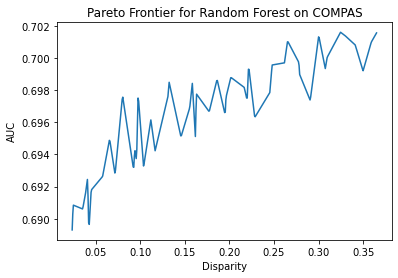

In [9]:
interploation_model = interp1d(dis_RF, acc_RF, kind = "linear")
 
# Plotting the Graph
X_RF=np.linspace(dis_RF.min(), dis_RF.max(), 500)
Y_RF=interploation_model(X_RF)
 
plt.plot(X_RF, Y_RF)
plt.title("Pareto Frontier for Random Forest on COMPAS")
plt.xlabel("Disparity")
plt.ylabel("AUC")
plt.show()

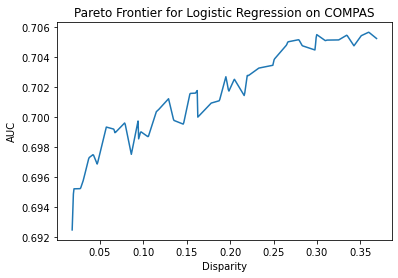

In [10]:
interploation_model = interp1d(dis_LR, acc_LR, kind = "linear")
 
# Plotting the Graph
X_LR=np.linspace(dis_LR.min(), dis_LR.max(), 500)
Y_LR=interploation_model(X_LR)
 
plt.plot(X_LR, Y_LR)
plt.title("Pareto Frontier for Logistic Regression on COMPAS")
plt.xlabel("Disparity")
plt.ylabel("AUC")
plt.show()

In [11]:
# define the trained logisctic regression model in the paper by Calmon
def RunLRClassifier(TrainList,TestList,TrainNewList,TestNewList,Z_features,X_features,Y_features):
    LRModelsAUC=[]
    LRTestPreds=[]
    for i in range(0,len(TrainNewList)):
        dft = pd.get_dummies(TrainNewList[i][Z_features+X_features])
        lr=LogisticRegression()
        lr.fit(dft,TrainNewList[i][Y_features])
        dft = pd.get_dummies(TestNewList[i][Z_features+X_features])
        proba=lr.predict_proba(dft)
        ytrue=TestList[i][Y_features]
        testauc=roc_auc_score(ytrue, proba[:, 1])
        LRModelsAUC.append(testauc)
        dft=TestList[i][Z_features+X_features+Y_features]
        dft['pred']=proba[:,1]
        LRTestPreds.append(dft)
    return LRModelsAUC,LRTestPreds

# define the logistic regression model without using the sensitive information
def RunLRWithoutDClassifier(TrainList,TestList,Z_features,X_features,Y_features):
    LRModelsAUC=[]
    LRTestPreds=[]
    for i in range(0,len(TrainList)): 
        dft = pd.get_dummies(TrainList[i][X_features])
        lr=LogisticRegression()
        lr.fit(dft,TrainList[i][Y_features])
        dft = pd.get_dummies(TestList[i][X_features])
        proba=lr.predict_proba(dft)
        ytrue=TestList[i][Y_features]
        testauc=roc_auc_score(ytrue, proba[:, 1])
        LRModelsAUC.append(testauc)
        dft=TestList[i][Z_features+X_features+Y_features]
        dft['pred']=proba[:,1]
        LRTestPreds.append(dft)
    return LRModelsAUC,LRTestPreds

# define the standard logistic regression model
def RunPlainLRClassifier(TrainList,TestList,Z_features,X_features,Y_features):
    LRModelsAUC=[]
    LRTestPreds=[]
    for i in range(0,len(TrainList)): 
        dft = pd.get_dummies(TrainList[i][Z_features+X_features])
        lr=LogisticRegression()
        lr.fit(dft,TrainList[i][Y_features])
        dft = pd.get_dummies(TestList[i][Z_features+X_features])
        proba=lr.predict_proba(dft)
        ytrue=TestList[i][Y_features]
        testauc=roc_auc_score(ytrue, proba[:, 1])
        LRModelsAUC.append(testauc)
        dft=TestList[i][Z_features+X_features+Y_features]
        dft['pred']=proba[:,1]
        LRTestPreds.append(dft)
    return LRModelsAUC,LRTestPreds

# define the trained random forest model in the paper by Calmon
def RunRFClassifier(TrainList,TestList,TrainNewList,TestNewList,Z_features,X_features,Y_features):
    RFModelsAUC=[]
    RFTestPreds=[]
    for i in range(0,len(TrainNewList)):
        dft = pd.get_dummies(TrainNewList[i][Z_features+X_features])
        rf=RandomForestClassifier()
        rf.fit(dft,TrainNewList[i][Y_features])
        dft = pd.get_dummies(TestNewList[i][Z_features+X_features])
        proba=rf.predict_proba(dft)
        ytrue=TestList[i][Y_features]
        testauc=roc_auc_score(ytrue, proba[:, 1])
        RFModelsAUC.append(testauc)
        dft=TestList[i][Z_features+X_features+Y_features]
        dft['pred']=proba[:,1]
        RFTestPreds.append(dft)
    return RFModelsAUC,RFTestPreds

# define the random forest model without using the sensitive information
def RunRFWithoutDClassifier(TrainList,TestList,Z_features,X_features,Y_features):
    RFModelsAUC=[]
    RFTestPreds=[]
    for i in range(0,len(TrainList)): 
        dft = pd.get_dummies(TrainList[i][X_features])
        rf=RandomForestClassifier()
        rf.fit(dft,TrainList[i][Y_features])
        dft = pd.get_dummies(TestList[i][X_features])
        proba=rf.predict_proba(dft)
        ytrue=TestList[i][Y_features]
        testauc=roc_auc_score(ytrue, proba[:, 1])
        RFModelsAUC.append(testauc)
        dft=TestList[i][Z_features+X_features+Y_features]
        dft['pred']=proba[:,1]
        RFTestPreds.append(dft)
    return RFModelsAUC,RFTestPreds

# define the standard random forest model
def RunPlainRFClassifier(TrainList,TestList,Z_features,X_features,Y_features):
    RFModelsAUC=[]
    RFTestPreds=[]
    for i in range(0,len(TrainList)): 
        dft = pd.get_dummies(TrainList[i][Z_features+X_features])
        rf=RandomForestClassifier()
        rf.fit(dft,TrainList[i][Y_features])
        dft = pd.get_dummies(TestList[i][Z_features+X_features])
        proba=rf.predict_proba(dft)
        ytrue=TestList[i][Y_features]
        testauc=roc_auc_score(ytrue, proba[:, 1])
        RFModelsAUC.append(testauc)
        dft=TestList[i][Z_features+X_features+Y_features]
        dft['pred']=proba[:,1]
        RFTestPreds.append(dft)
    return RFModelsAUC,RFTestPreds

# compute the discrimition
def ComputeDiscrimination(LRTestPreds,Z_features):
    test_disc=[]
    for i in range(0,len(LRTestPreds)):
        mean = LRTestPreds[i].groupby(Z_features)['pred'].mean()
        v = mean.values
        v = v.reshape(len(v),1)
        ratio_df = pd.DataFrame(v/v.transpose(),index=mean.index,columns=mean.index )
        ratio_df_arr=np.asarray(np.abs(1-ratio_df))
        maxdisc=np.amax(ratio_df_arr)
        test_disc.append(maxdisc)   
    return test_disc

In [14]:
# Random Forest Comparison Experiment
RFres_RFClassifier=RunRFClassifier(TrainList,TestList,TrainNewList,TestNewList,Z_features,X_features,Y_features)
RFres_PlainRFClassifier=RunPlainRFClassifier(TrainList,TestList,Z_features,X_features,Y_features)
RFres_RFWithoutDClassifier=RunRFWithoutDClassifier(TrainList,TestList,Z_features,X_features,Y_features)
RFDisc_RFClassifier=ComputeDiscrimination(RFres_RFClassifier[1],Z_features)
RFDisc_PlainRFClassifier=ComputeDiscrimination(RFres_PlainRFClassifier[1],Z_features)
RFDisc_RFWithoutDClassifier=ComputeDiscrimination(RFres_RFWithoutDClassifier[1],Z_features)

from scipy.stats import t
RFAUC1=np.asarray(RFres_RFClassifier[0])
RFAUC2=np.asarray(RFres_PlainRFClassifier[0])
RFAUC3=np.asarray(RFres_RFWithoutDClassifier[0])
RFAUC4=np.asarray(np.array(RFModelsAUC_path_list)[:,49])
RF_mean1 = np.mean(RFAUC1)
RF_mean2 = np.mean(RFAUC2)
RF_mean3 = np.mean(RFAUC3)
RF_mean4 = np.mean(RFAUC4)

zemelauc=np.asarray([0.676842373423,0.693,0.687,0.693,0.699])
#zemelauc=np.asarray([0.706,0.682,0.701,0.705,0.706])
zemel_mean=np.mean(zemelauc)

# standard deviation
RF_std1 = np.std(RFAUC1)
RF_std2 = np.std(RFAUC2)
RF_std3 = np.std(RFAUC3)
RF_std4 = np.std(RFAUC4)
zemel_std=np.std(zemelauc)

RFDisc1=np.asarray(RFDisc_RFClassifier)
RFDisc2=np.asarray(RFDisc_PlainRFClassifier)
RFDisc3=np.asarray(RFDisc_RFWithoutDClassifier)
RFDisc4=np.asarray(np.array(RFDisc_path_list)[:,49])
RFdisc_mean1 = np.mean(RFDisc1)
RFdisc_mean2 = np.mean(RFDisc2)
RFdisc_mean3 = np.mean(RFDisc3)
RFdisc_mean4 = np.mean(RFDisc4)
RFdisc_std1=np.std(RFDisc1)
RFdisc_std2=np.std(RFDisc2)
RFdisc_std3=np.std(RFDisc3)
RFdisc_std4=np.std(RFDisc4)

zemel_disc=np.asarray([0.0197,0.0122,0.0149,0.046])
#zemel_disc=np.asarray([0.265,0.375,0.284,0.303,0.330])
zemel_disc_mean=np.mean(zemel_disc)
zemel_disc_std=np.std(zemel_disc)

# Logistic Regression Comparison Experiment
LRres_LRClassifier=RunLRClassifier(TrainList,TestList,TrainNewList,TestNewList,Z_features,X_features,Y_features)
LRres_PlainLRClassifier=RunPlainLRClassifier(TrainList,TestList,Z_features,X_features,Y_features)
LRres_LRWithoutDClassifier=RunLRWithoutDClassifier(TrainList,TestList,Z_features,X_features,Y_features)
LRDisc_LRClassifier=ComputeDiscrimination(LRres_LRClassifier[1],Z_features)
LRDisc_PlainLRClassifier=ComputeDiscrimination(LRres_PlainLRClassifier[1],Z_features)
LRDisc_LRWithoutDClassifier=ComputeDiscrimination(LRres_LRWithoutDClassifier[1],Z_features)

from scipy.stats import t
LRAUC1=np.asarray(LRres_LRClassifier[0])
LRAUC2=np.asarray(LRres_PlainLRClassifier[0])
LRAUC3=np.asarray(LRres_LRWithoutDClassifier[0])
LRAUC4=np.asarray(np.array(LRModelsAUC_path_list)[:,49])
LR_mean1 = np.mean(LRAUC1)
LR_mean2 = np.mean(LRAUC2)
LR_mean3 = np.mean(LRAUC3)
LR_mean4 = np.mean(LRAUC4)

zemelauc=np.asarray([0.676842373423,0.693,0.687,0.693,0.699])
zemel_mean=np.mean(zemelauc)

# standard deviation
LR_std1 = np.std(LRAUC1)
LR_std2 = np.std(LRAUC2)
LR_std3 = np.std(LRAUC3)
LR_std4 = np.std(LRAUC4)
zemel_std=np.std(zemelauc)

LRDisc1=np.asarray(LRDisc_LRClassifier)
LRDisc2=np.asarray(LRDisc_PlainLRClassifier)
LRDisc3=np.asarray(LRDisc_LRWithoutDClassifier)
LRDisc4=np.asarray(np.array(LRDisc_path_list)[:,49])
LRdisc_mean1 = np.mean(LRDisc1)
LRdisc_mean2 = np.mean(LRDisc2)
LRdisc_mean3 = np.mean(LRDisc3)
LRdisc_mean4 = np.mean(LRDisc4)
LRdisc_std1=np.std(LRDisc1)
LRdisc_std2=np.std(LRDisc2)
LRdisc_std3=np.std(LRDisc3)
LRdisc_std4=np.std(LRDisc4)

zemel_disc=np.asarray([0.0197,0.0122,0.0149,0.046])
zemel_disc_mean=np.mean(zemel_disc)
zemel_disc_std=np.std(zemel_disc)

<ipython-input-11-8cb1aa841593>:62: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(dft,TrainNewList[i][Y_features])
<ipython-input-11-8cb1aa841593>:62: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(dft,TrainNewList[i][Y_features])
<ipython-input-11-8cb1aa841593>:62: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(dft,TrainNewList[i][Y_features])
<ipython-input-11-8cb1aa841593>:62: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(dft,TrainNewList[i][Y_features])
<ipython-input-11-8cb1aa841593>:62: DataConversionWarning: A column-

## Generate Figures

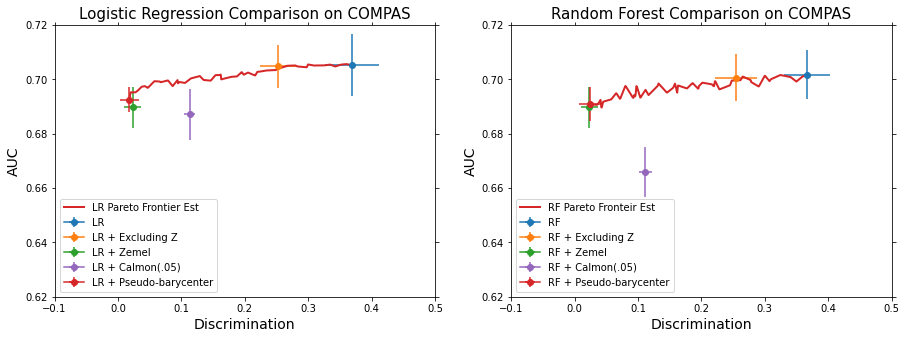

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].errorbar(LRdisc_mean2, LR_mean2, xerr=LRdisc_std2, yerr=LR_std2, fmt='-o') # LR
axs[0].errorbar(LRdisc_mean3, LR_mean3, xerr=LRdisc_std3, yerr=LR_std3, fmt='-o') # LR + Excluding Z
axs[0].errorbar(zemel_disc_mean, zemel_mean, xerr=zemel_disc_std, yerr=zemel_std, fmt='-o') # LR + Zemel
axs[0].errorbar(LRdisc_mean1, LR_mean1, xerr=LRdisc_std1, yerr=LR_std1, fmt='-o',color = '#9467bd') # LR + Calmon(0.05)
axs[0].errorbar(LRdisc_mean4, LR_mean4, xerr=LRdisc_std4, yerr=LR_std4, fmt='-o',color = '#d62728') # LR + pseudo-barycenter
axs[0].plot(X_LR, Y_LR, linewidth = 2, color = '#d62728') # LR Pareto Frontier Estimation



axs[0].tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="on", right="off", labelleft="on")  

axs[0].legend(['LR Pareto Frontier Est','LR','LR + Excluding Z','LR + Zemel','LR + Calmon(.05)','LR + Pseudo-barycenter'], 
           loc='best',fancybox=True)

axs[0].set_ylabel('AUC', fontsize=14)
axs[0].set_xlabel('Discrimination', fontsize=14)
axs[0].set_title(f"Logistic Regression Comparison on COMPAS", fontsize=15)
axs[0].set_ylim(0.62, 0.72)
axs[0].set_xlim(-0.1, 0.5)


axs[1].errorbar(RFdisc_mean2, RF_mean2, xerr=RFdisc_std2, yerr=RF_std2, fmt='-o') # RF
axs[1].errorbar(RFdisc_mean3, RF_mean3, xerr=RFdisc_std3, yerr=RF_std3, fmt='-o') # RF + Excluding Z
axs[1].errorbar(zemel_disc_mean, zemel_mean, xerr=zemel_disc_std, yerr=zemel_std, fmt='-o') # LR + Zemel
axs[1].errorbar(RFdisc_mean1, RF_mean1, xerr=RFdisc_std1, yerr=RF_std1, fmt='-o',color = '#9467bd') # RF + Calmon(0.05)
axs[1].errorbar(RFdisc_mean4, RF_mean4, xerr=RFdisc_std4, yerr=RF_std4, fmt='-o',color = '#d62728') # RF + pseudo-barycenter
axs[1].plot(X_RF, Y_RF, linewidth = 2, color = '#d62728') # LR Pareto Frontier Estimation



#fig.axes.get_xaxis().set_visible(False)

axs[1].tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="on", right="off", labelleft="on")  

axs[1].legend(['RF Pareto Fronteir Est','RF','RF + Excluding Z','RF + Zemel','RF + Calmon(.05)','RF + Pseudo-barycenter'], 
           loc='best',fancybox=True)

axs[1].set_ylabel('AUC', fontsize=14)
axs[1].set_xlabel('Discrimination', fontsize=14)
axs[1].set_title(f"Random Forest Comparison on COMPAS", fontsize=15)
axs[1].set_ylim(0.62, 0.72)
axs[1].set_xlim(-0.1, 0.5)

fig.subplots_adjust(wspace=0.2,hspace=0.2)
plt.savefig('Pareto Frontier COMPAS', dpi=400,bbox_inches='tight')